## Facial Attribute Detection Using Convolutional Neural Networks

### Convolutional Neural Network

**Team Members**   
Sike Ogieva and Lee Mabhena  

Dataset is sourced from: https://www.kaggle.com/datasets/jessicali9530/celeba-dataset?select=list_attr_celeba.csv   

---


In [42]:
import io
import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, hamming_loss
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import EarlyStopping

---
**Code To Read And Parse TF Records**


In [2]:
def parse_tfrecord(example_proto):
    feature_description = {
        'image': tf.io.FixedLenFeature([], tf.string),
        'features': tf.io.FixedLenFeature([40], tf.float32)
    }
    return tf.io.parse_single_example(example_proto, feature_description)

def decode_image_and_resize(features):
    image = tf.image.decode_jpeg(features['image'], channels=3)
    image = tf.image.resize(image, [150, 150])  # (178, 218) Resize to the input size required by the model
    return image, features['features']

def load_dataset(tfrecord_file, start_index, end_index):
    dataset = tf.data.TFRecordDataset(tfrecord_file)
    dataset = dataset.enumerate().filter(lambda idx, _: idx >= start_index and idx < end_index)
    dataset = dataset.map(lambda idx, data: parse_tfrecord(data))
    dataset = dataset.map(decode_image_and_resize)
    return dataset

---
**Load and Normalise Data**

In [3]:
# Define the portion of data to use
train_num = 40_000
valid_num = 10_000
test_num =  10_000

In [4]:
# Load it in
train_dataset = load_dataset('output.tfrecords', 0, train_num) # 0 - 162770
validation_dataset = load_dataset('output.tfrecords', 162771, 162771 + valid_num) # 162771, 182637
test_dataset = load_dataset('output.tfrecords', 182638, 182638 + test_num) # 182638, 202599

In [5]:
train_dataset

<_MapDataset element_spec=(TensorSpec(shape=(150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(40,), dtype=tf.float32, name=None))>

In [6]:
def normalize_image(image, label):
    image = tf.cast(image, tf.float32) / 255.0  # Normalize to [0, 1]
    return image, label

# Apply the normalization to the train, validation, and test datasets
train_dataset = train_dataset.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.map(normalize_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Prefetch data for faster consumption
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
# Batch the dataset
batch_size = 128

train_dataset = train_dataset.batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

In [20]:
test_dataset = test_dataset.batch(batch_size)

---
**Model Definition**


In [9]:
input_shape = (150, 150, 3)

In [10]:
# model definition
model = Sequential()

model.add(Input(shape = input_shape))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPool2D((2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))

model.add(Dense(40, activation='sigmoid')) # output layer

In [17]:
model.save("transfer_learning_model.h5")

C:\Users\ogiev\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


 ---
 
 **Custom Evaluation**

The in-built evaluation metrics calculate whether for each image, the model has predicted every single one of the 40 attributes correctly and if it misses even one, the whole row is counted as inaccurate-- which would result in unrepresentatively low accuracies.

So here, we write our own evaluation metrics.

In [18]:
class CustomAccuracy(tf.keras.metrics.Metric):
    
    def __init__(self, name='custom_accuracy', **kwargs):
        super(CustomAccuracy, self).__init__(name=name, **kwargs)
        
        # Initialize the necessary variables for true positives, true negatives, etc.
        self.true_positives = self.add_weight(name='tp', initializer='zeros')
        self.true_negatives = self.add_weight(name='tn', initializer='zeros')
        self.false_positives = self.add_weight(name='fp', initializer='zeros')
        self.false_negatives = self.add_weight(name='fn', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions and true values to binary (0 or 1)
        y_pred = tf.round(y_pred)
        y_true = tf.cast(y_true, tf.bool)
        y_pred = tf.cast(y_pred, tf.bool)

        # Calculate true positives, true negatives, false positives, and false negatives
        self.true_positives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, True)), tf.float32)))
        self.true_negatives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, False)), tf.float32)))
        self.false_positives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, False), tf.equal(y_pred, True)), tf.float32)))
        self.false_negatives.assign_add(tf.reduce_sum(tf.cast(tf.logical_and(tf.equal(y_true, True), tf.equal(y_pred, False)), tf.float32)))

    def result(self):
        # Compute accuracy
        total_correct = self.true_positives + self.true_negatives
        total = self.true_positives + self.true_negatives + self.false_positives + self.false_negatives
        return total_correct / total

    def reset_state(self):
        # The state of the metric will be reset at the start of each epoch.
        self.true_positives.assign(0.)
        self.true_negatives.assign(0.)
        self.false_positives.assign(0.)
        self.false_negatives.assign(0.)
        
custom_accuracy = CustomAccuracy()

In [12]:
class MultiLabelAccuracy(tf.keras.metrics.Metric):
    def __init__(self, name="multilabel_accuracy", **kwargs):
        super(MultiLabelAccuracy, self).__init__(name=name, **kwargs)
        self.total = self.add_weight("total", initializer="zeros")
        self.count = self.add_weight("count", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred = tf.round(y_pred)  # Convert probabilities to 1 or 0
        # Ensure both y_true and y_pred are cast to boolean for logical operations
        y_true_bool = tf.cast(y_true, tf.bool)
        y_pred_bool = tf.cast(y_pred, tf.bool)

        intersection = tf.reduce_sum(tf.cast(tf.logical_and(y_true_bool, y_pred_bool), tf.float32), axis=1)
        union = tf.reduce_sum(tf.cast(tf.logical_or(y_true_bool, y_pred_bool), tf.float32), axis=1)
        accuracy = intersection / union
        self.total.assign_add(tf.reduce_sum(accuracy))
        self.count.assign_add(tf.cast(tf.size(accuracy), tf.float32))

    def result(self):
        return self.total / self.count

    def reset_state(self):
        self.total.assign(0.0)
        self.count.assign(0.0)

multi_label_accuracy = MultiLabelAccuracy()

---  

**Model Compilation And Training**

In [14]:
# Compile the model
model.compile(optimizer=tf.keras.optimizers.legacy.Adam(),
              loss='binary_crossentropy',
              metrics=[multi_label_accuracy, custom_accuracy])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 148, 148, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 74, 74, 32)        9248      
                                                                 
 conv2d_3 (Conv2D)           (None, 74, 74, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 37, 37, 32)        0         
 g2D)                                                   

In [15]:
# training
network_history = model.fit(
    train_dataset, 
    batch_size = 128,
    epochs = 10, 
    validation_data = validation_dataset, 
    verbose = 1,
    callbacks = [ EarlyStopping(patience = 5, min_delta = 0.01, restore_best_weights = True) ]
)

Epoch 1/1000000000

313/313 [==============================] - 467s 1s/step - loss: 0.3554 - multilabel_accuracy: 0.4025 - custom_accuracy: 0.8432 - val_loss: 0.2896 - val_multilabel_accuracy: 0.5145 - val_custom_accuracy: 0.8742
Epoch 2/1000000000
313/313 [==============================] - 589s 2s/step - loss: 0.2702 - multilabel_accuracy: 0.5360 - custom_accuracy: 0.8819 - val_loss: 0.2551 - val_multilabel_accuracy: 0.5642 - val_custom_accuracy: 0.8894
Epoch 3/1000000000
313/313 [==============================] - 572s 2s/step - loss: 0.2462 - multilabel_accuracy: 0.5710 - custom_accuracy: 0.8915 - val_loss: 0.2427 - val_multilabel_accuracy: 0.5826 - val_custom_accuracy: 0.8937
Epoch 4/1000000000
313/313 [==============================] - 437s 1s/step - loss: 0.2332 - multilabel_accuracy: 0.5913 - custom_accuracy: 0.8970 - val_loss: 0.2384 - val_multilabel_accuracy: 0.5944 - val_custom_accuracy: 0.8951
Epoch 5/1000000000
313/313 [==============================] - 475s 2s/step - loss: 

---
**Model Evaluation**

In [21]:
# Evaluate the model
probabilities = model.predict(test_dataset)
predictions = []
for i in range(len(probabilities)):
    predictions.append((probabilities[i] >= 0.5).astype(int))

79/79 [==============================] - 26s 251ms/step


In [23]:
true_labels = []
predicted_labels = []

for images, labels in test_dataset:
    preds = model.predict(images)
    true_labels.extend(labels.numpy())  # Assuming labels are in TensorFlow format
    predicted_labels.extend((preds >= 0.5).astype(int))

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)

1/1 [==============================] - 0s 181ms/step


Confusion Matrix

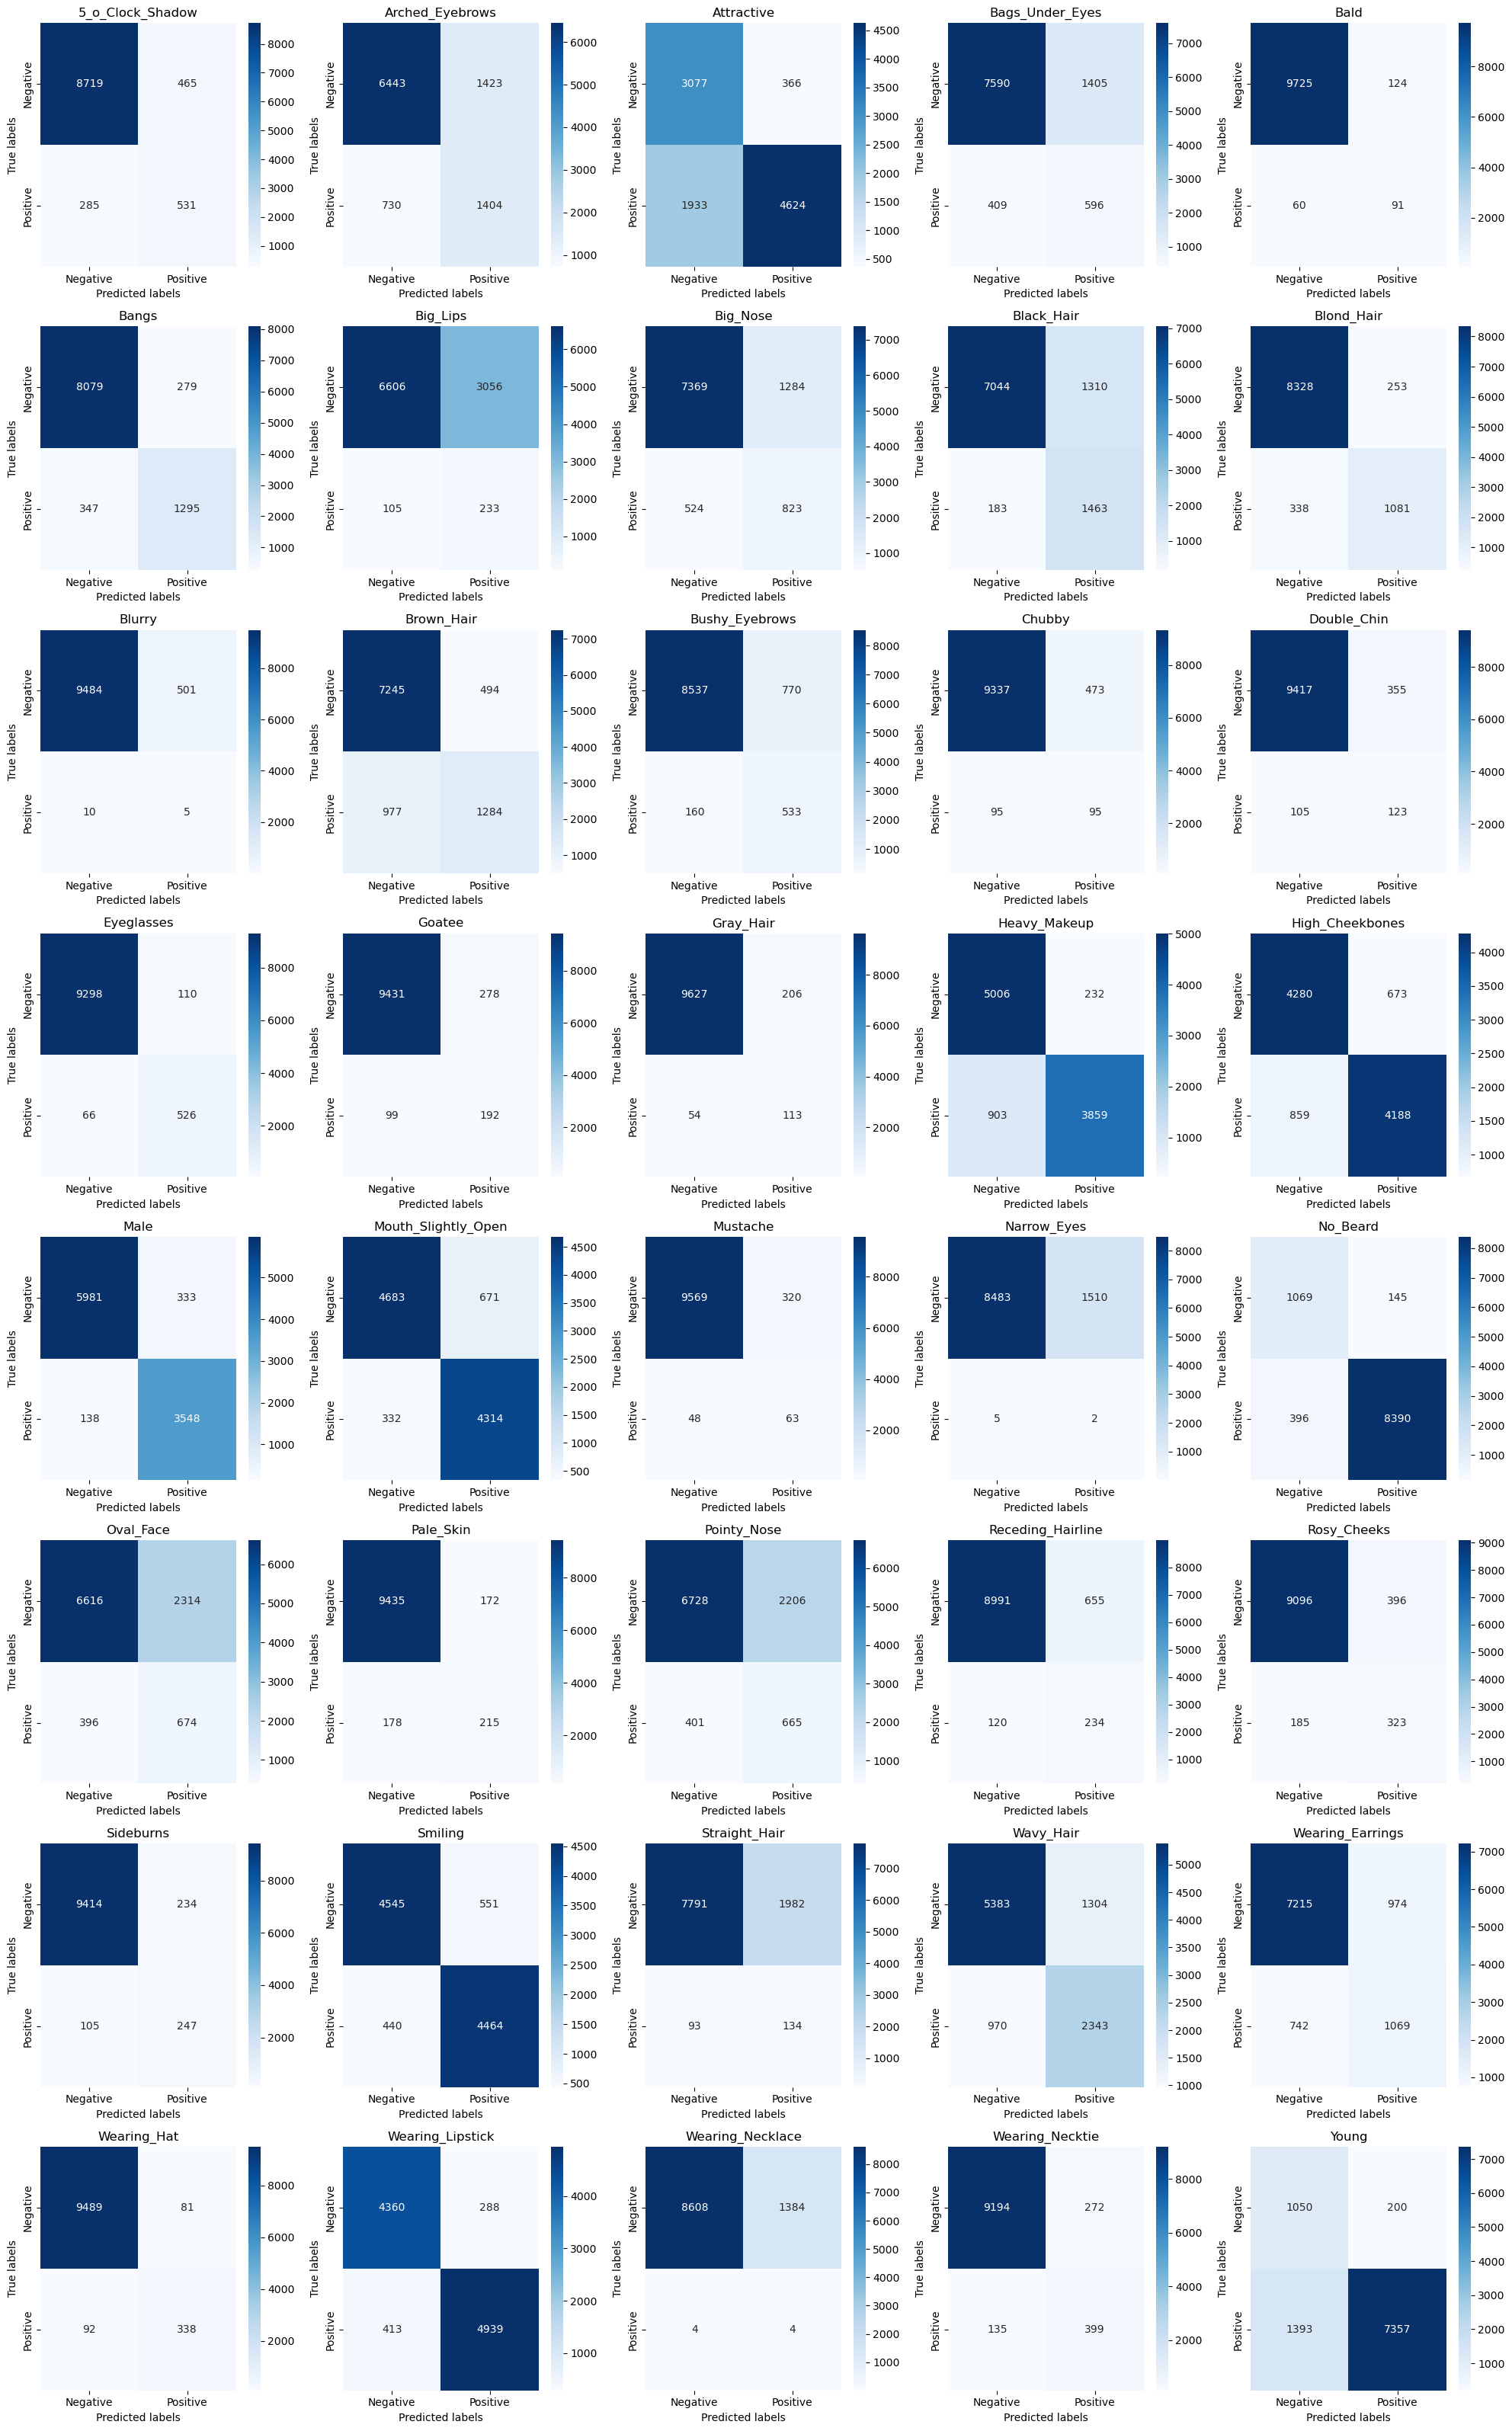

In [26]:
df = pd.read_csv("archive/list_attr_celeba.csv")
feature_columns = df.columns.tolist()
feature_columns.remove('image_id')

def draw_confusion_plots(true_labels, predicted_labels, feature_columns = feature_columns):
    conf_matrices = multilabel_confusion_matrix(predicted_labels, true_labels)
    fig, axes = plt.subplots(8, 5, figsize=(20, 32))  # Adjusted to 8x5 grid with appropriate figsize

    for i, cm in enumerate(conf_matrices):
        # Locate the position in the grid
        row = i // 5
        col = i % 5
        ax = axes[row, col]  # Access the subplot position
        
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
        ax.set_title(feature_columns[i])
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.xaxis.set_ticklabels(['Negative', 'Positive'])
        ax.yaxis.set_ticklabels(['Negative', 'Positive'])

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()

draw_confusion_plots(true_labels, predicted_labels)

Classic Metrics

In [24]:
def hamming_score(y_true, y_pred):
    temp = 0
    for i in range(y_true.shape[0]):
        temp += sum(np.logical_and(y_true[i], y_pred[i])) / sum(np.logical_or(y_true[i], y_pred[i]))
    return temp / y_true.shape[0]

0.5752849090181452

In [41]:
print('Hamming loss: {0}'.format(hamming_loss(true_labels, predicted_labels))) 
print('Recall: {0}'.format(precision_score(y_true=true_labels, y_pred=predicted_labels, average='samples'))) 
print('Precision: {0}'.format(recall_score(y_true=true_labels, y_pred=predicted_labels, average='samples')))
print('F1 Measure: {0}'.format(f1_score(y_true=true_labels, y_pred=predicted_labels, average='samples'))) 
print('Hamming score: {0}'.format(hamming_score(true_labels, predicted_labels))) 

Hamming loss: 0.1121925
Recall: 0.8035565218115218
Precision: 0.6681687959542177
F1 Measure: 0.7145281190121147
Hamming score: 0.5752849090181452


Looking for better threshold. To find the best threshold for each of the 40 labels in a highly imbalanced multilabel classification setting, we make use of a technique based on optimizing the F1 score for each label independently. The F1 score is a balanced measure that considers both precision and recall, making it particularly useful in the context of imbalanced datasets.

In [28]:
# compute predictions for validation data
y_pred_probs = model.predict(validation_dataset)

79/79 [==============================] - 35s 316ms/step


In [30]:
def calculate_f1_for_threshold(y_true, y_prob, threshold):
    y_pred = (y_prob >= threshold).astype(int)
    return f1_score(y_true, y_pred)

def get_true_labels(data):
    y_true = []
    for _, labels in data:
        y_true.append(labels)

    # Concatenate all the tensors in the list along the first dimension
    # This results in a single tensor of shape (num_samples, num_labels)
    y_true = tf.concat(y_true, axis=0)

    # To convert this tensor to a numpy array if needed:
    y_true = y_true.numpy()
    return y_true

y_true = get_true_labels(validation_dataset)

def find_best_thresholds(y_true, y_pred_probs):
    best_thresholds = []
    for i in range(y_pred_probs.shape[1]):  # Assuming y_pred_probs is shape (num_samples, num_labels)
        label_probs = y_pred_probs[:, i]
        label_true = y_true[:, i]
        
        thresholds = np.linspace(0, 1, 100)  # 100 points between 0 and 1
        f1_scores = [calculate_f1_for_threshold(label_true, label_probs, t) for t in thresholds]
        best_threshold = thresholds[np.argmax(f1_scores)]
        best_thresholds.append(best_threshold)
        
        print(f"Label {i} - Best Threshold: {best_threshold} with F1 Score: {max(f1_scores)}")
    
    return best_thresholds

In [33]:
best_thresholds = find_best_thresholds(y_true, y_pred_probs)

Label 0 - Best Threshold: 0.36363636363636365 with F1 Score: 0.6410852713178296
Label 1 - Best Threshold: 0.29292929292929293 with F1 Score: 0.6524013314312886
Label 2 - Best Threshold: 0.595959595959596 with F1 Score: 0.8030534351145038
Label 3 - Best Threshold: 0.27272727272727276 with F1 Score: 0.5570495582020745
Label 4 - Best Threshold: 0.31313131313131315 with F1 Score: 0.5436105476673427
Label 5 - Best Threshold: 0.4545454545454546 with F1 Score: 0.7944942381562099
Label 6 - Best Threshold: 0.31313131313131315 with F1 Score: 0.38705556738343627
Label 7 - Best Threshold: 0.26262626262626265 with F1 Score: 0.6106629252893722
Label 8 - Best Threshold: 0.30303030303030304 with F1 Score: 0.7462469733656175
Label 9 - Best Threshold: 0.5757575757575758 with F1 Score: 0.7828685258964142
Label 10 - Best Threshold: 0.18181818181818182 with F1 Score: 0.33201581027667987
Label 11 - Best Threshold: 0.36363636363636365 with F1 Score: 0.6608664772727273
Label 12 - Best Threshold: 0.33333333333

Now, we apply the thresholds and re-evaluate the test set.

In [35]:
true_test_label = get_true_labels(test_dataset)
test_preds  = model.predict(test_dataset)

def apply_thresholds(y_probs, thresholds):
    return (y_probs >= thresholds).astype(int)

pred_labels = apply_thresholds(test_preds, best_thresholds)

79/79 [==============================] - 35s 310ms/step


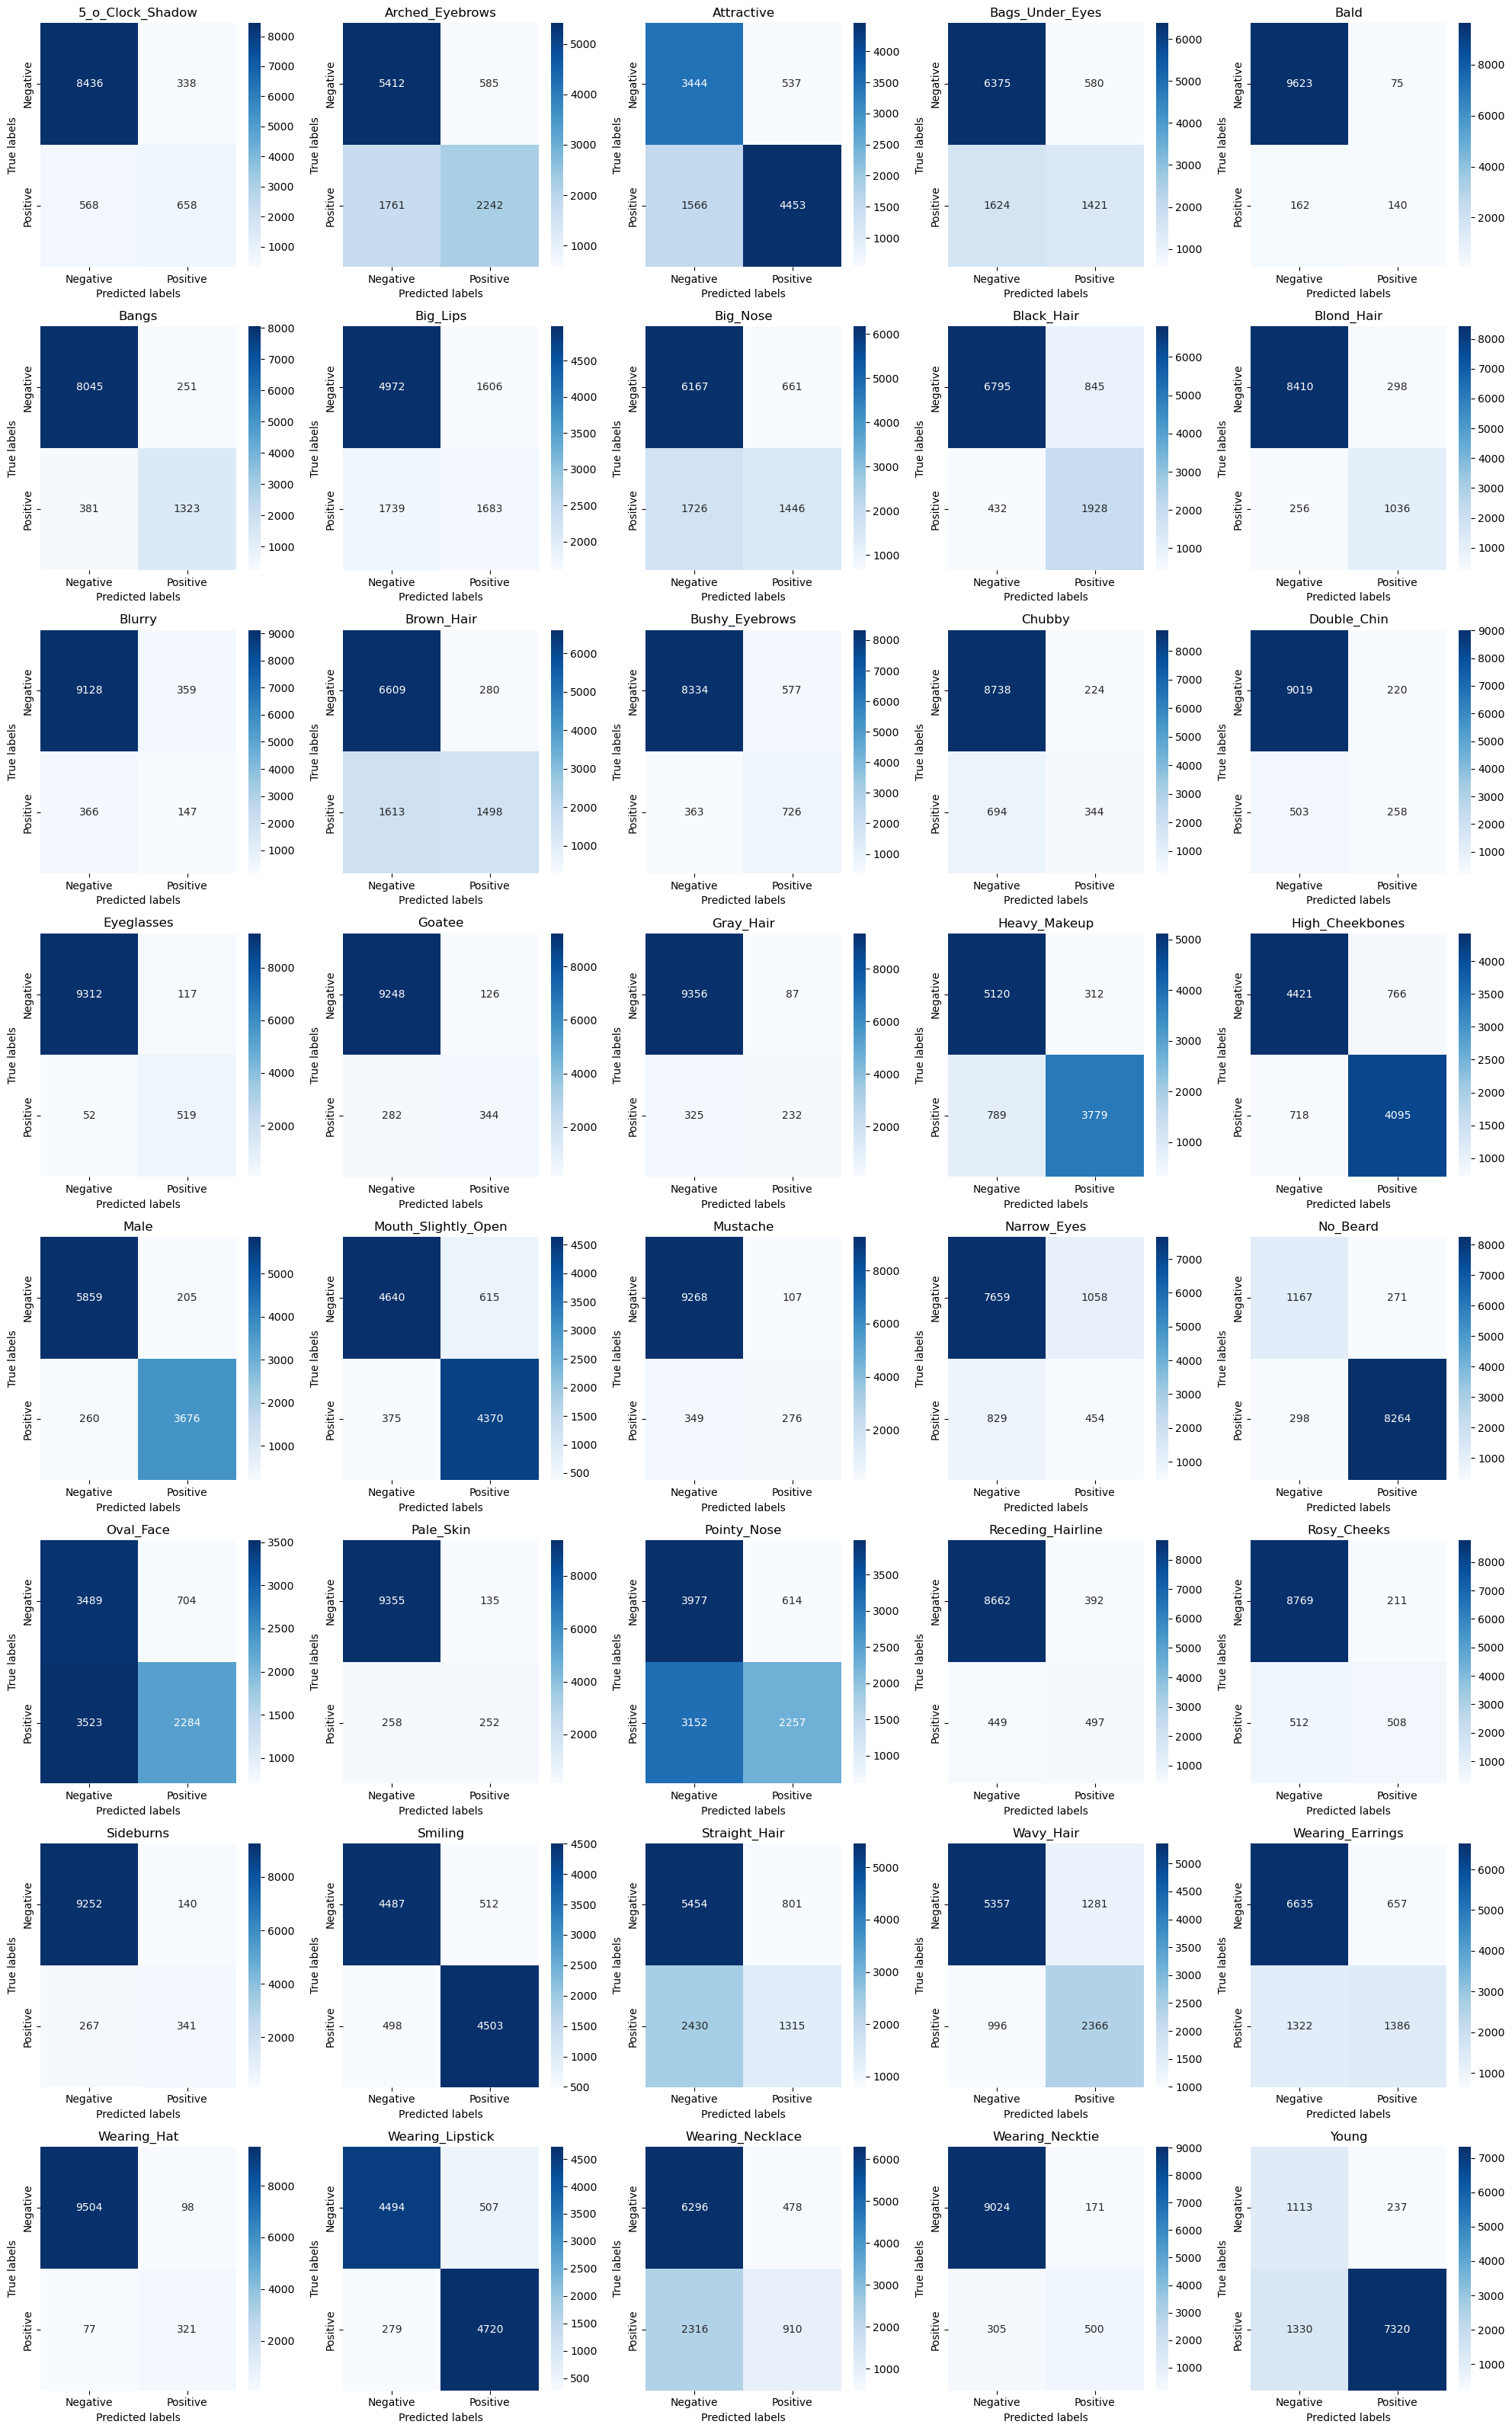

In [39]:
# Draw the confusion matrices
draw_confusion_plots(true_test_label, pred_labels)

In [43]:
print('Hamming loss: {0}'.format(hamming_loss(true_labels, predicted_labels))) 
print('Recall: {0}'.format(precision_score(y_true=true_labels, y_pred=predicted_labels, average='samples'))) 
print('Precision: {0}'.format(recall_score(y_true=true_labels, y_pred=predicted_labels, average='samples')))
print('F1 Measure: {0}'.format(f1_score(y_true=true_labels, y_pred=predicted_labels, average='samples'))) 
print('Hamming Score: {0}'.format(hamming_score(true_test_label, pred_labels)))

Hamming loss: 0.1121925
Recall: 0.8035565218115218
Precision: 0.6681687959542177
F1 Measure: 0.7145281190121147
Hamming Score: 0.5710902397933262
